In [120]:
import numpy as np
from matplotlib import pyplot as plt

# Prepare some data
def foo(x):
    return x * np.sin(x) + 0.2 * x
#     return x ** 2

N = 256
# X = np.concatenate(
#     [np.random.uniform(low = -2.6, high = -1, size = (N // 8 * 5,)),
#     np.random.uniform(low = 2, high = 2.6, size = (N // 8 * 3,))])
X = np.random.uniform(low = -2.6, high = 2.6, size = (N,))
Y = foo(X)

X_GT = np.linspace(-3, 3, num = 256)
Y_GT = foo(X_GT)

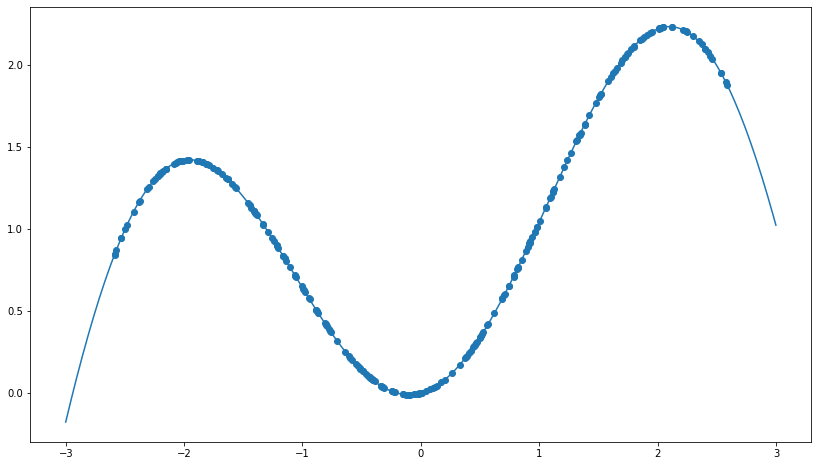

In [121]:
fig = plt.figure(figsize = (14, 8))
plt.scatter(X, Y)
plt.plot(X_GT, Y_GT)
plt.show()

In [122]:
import torch
from torch import nn

input_dim = 1
hidden_dim = 1024
output_dim = 1

nonlin = nn.Tanh()

Y_mean_all = []
N_trials = 1

def obtain_embedding(net, x):
    ygp = net[0](x.view(-1, 1))
    ygp = net[1](ygp)
    act = (ygp.unsqueeze(1) * net[-1].weight.unsqueeze(0)).squeeze().detach()
    
    return act

acts = []
acts2= []

for trials in range(N_trials):
    
    print("Trial %d" % trials)
    
    net = nn.Sequential(
        nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nonlin,
            nn.Linear(hidden_dim, hidden_dim),
        ),
#         nn.Linear(input_dim, hidden_dim),
        nonlin,
    #     nn.Dropout(0.5),
        nn.Linear(hidden_dim, output_dim)
    )

    # optim = torch.optim.SGD(net.parameters(), lr=1e-4, weight_decay = 1e-3)
    optim = torch.optim.Adam(net.parameters(), lr=1e-3)
    # print(list(net.parameters()))

    net = net.cuda()
    Xs = torch.FloatTensor(X).cuda().view(-1, 1)
    Ys = torch.FloatTensor(Y).cuda().view(-1, 1)
    
    # Only 1 single point
#     Xs = Xs[0:1]
#     Ys = Ys[0:1]
    
    acts.append(obtain_embedding(net, Xs[0]))
    acts2.append(obtain_embedding(net, Xs[1]))

    # lossFn = nn.MSELoss()
    lossFn = nn.L1Loss()

    net.train()

    steps = 100
    for i in range(steps):
        pred = net(Xs)
        loss = lossFn(pred, Ys)
        loss.backward()
        optim.step()

        if i % (steps // 50) == (steps // 50) - 1:
            acts.append(obtain_embedding(net, Xs[0]))
            acts2.append(obtain_embedding(net, Xs[1]))
#             print("%d: %f" % (i + 1, loss))

    acts.append(obtain_embedding(net, Xs[0]))
    acts2.append(obtain_embedding(net, Xs[1]))

#     net.eval()

#     # Random dropout samplings
#     Y_pred = net(Xs).detach().cpu().squeeze()

#     Y_GT_pred = []
#     N_samples = 20
#     for i in range(N_samples):
#         ygp = net[0](torch.FloatTensor(X_GT).cuda().view(-1, 1))
#         ygp = net[1](ygp)
#         ygp = ygp * torch.randint(2, size = (ygp.shape[-1],), device = ygp.device).unsqueeze(0) * 2
#         ygp = net[-1](ygp)
#         Y_GT_pred.append(ygp.detach().cpu().squeeze())

#     # Std
#     ygp = net[0](torch.FloatTensor(X_GT).cuda().view(-1, 1))
#     ygp = net[1](ygp)
#     Y_std = (ygp.unsqueeze(1) * net[-1].weight.unsqueeze(0)).squeeze().std(dim = -1).detach().cpu()
#     Y_mean = net(torch.FloatTensor(X_GT).cuda().view(-1, 1)).detach().cpu()
    
#     Y_mean_all.append(Y_mean)

# print(Y_pred)

acts = torch.stack(acts, dim = 0).detach().cpu().numpy()
acts2 = torch.stack(acts2, dim = 0).detach().cpu().numpy()
print(acts.shape)

Trial 0
(52, 1024)


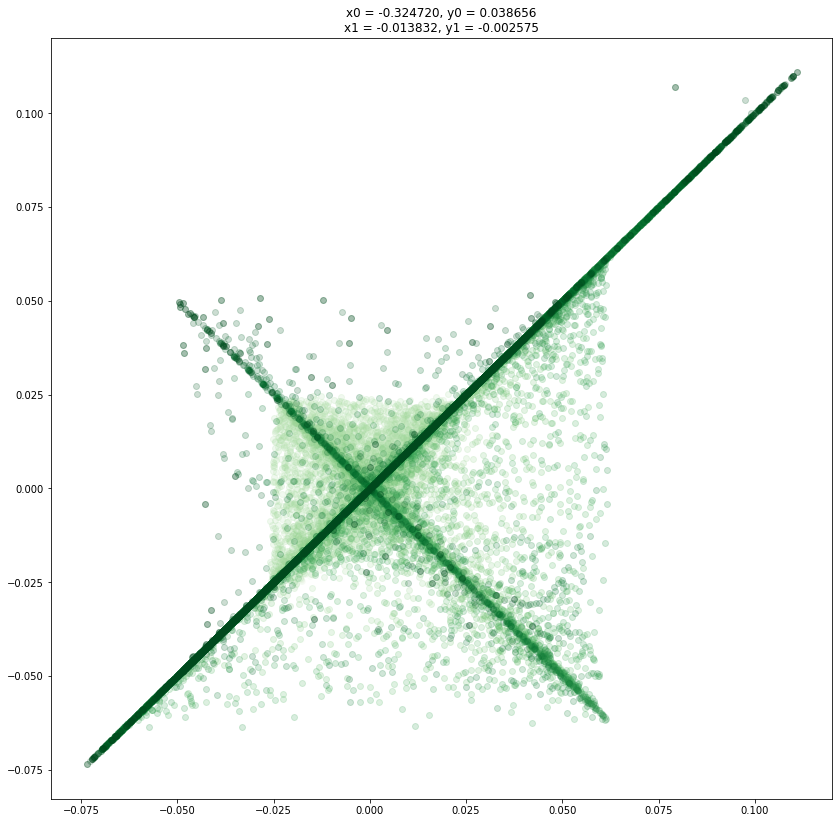

In [123]:
import math
import matplotlib as mpl

fig = plt.figure(figsize = (14, 14))
cmap = mpl.colormaps['Greens']
cmap_mean = mpl.colormaps['Oranges']

for i in range(len(acts)):
    progress = i / len(acts)
#     plt.scatter(acts[i], np.ones_like(acts[i]) * progress, color = cmap(progress), alpha = 0.5)
#     plt.scatter(acts[i].mean(), [progress], color = cmap_mean(progress), marker = 'x', s = 100)
    plt.scatter(acts[i], acts2[i], color = cmap(progress), alpha = 0.2)
    
# plt.scatter(act2, np.ones_like(act2), c = 'green', alpha = 0.2)
# plt.ylim(-0.2, 1.2)

# for i in range(N_samples):
# #     plt.plot(X_GT, Y_GT_pred[i], c = 'blue', alpha = 0.15)
#     pass

# for i in range(N_trials):
#     plt.plot(X_GT, Y_mean_all[i], c = 'red', alpha = 0.3)
#     pass

# plt.scatter(X, Y, c = 'blue', alpha = 0.25)
# # plt.plot(X_GT, Y_GT, c = 'orange')

# # plt.plot(X_GT, Y_mean[:, 0], c = 'blue')
# plt.plot(X_GT, Y_mean[:, 0] + math.sqrt(hidden_dim) * Y_std.numpy(), c = 'green')
# plt.plot(X_GT, Y_mean[:, 0] - math.sqrt(hidden_dim) * Y_std.numpy(), c = 'green')

# # plt.title("Blue: NN (last trial)\nOrange: GT\nRed: each trials\nGreen: MC-stddev (last trial)")
# plt.title("Blue: Dataset\nRed: each trials' NN function\nGreen: MC-bound (stddev, last trial)")
plt.title("x0 = %f, y0 = %f\nx1 = %f, y1 = %f" % (Xs[0], Ys[0], Xs[1], Ys[1]))

plt.show()